In [75]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
#export
from exp.nb_model import *
from torch.utils.data import DataLoader

## Initial setup

In [63]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = DataSet(x_train, y_train),DataSet(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [84]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [88]:
#export
from functools import partial

In [85]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [86]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.665689765625, tensor(0.8096)]
valid: [0.30300166015625, tensor(0.9144)]
train: [0.29844716796875, tensor(0.9138)]
valid: [0.2553117431640625, tensor(0.9265)]
train: [0.2416671484375, tensor(0.9305)]
valid: [0.221105810546875, tensor(0.9381)]


In [92]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.775801875, tensor(0.8001)]
valid: [0.3537445068359375, tensor(0.8994)]
train: [0.34822640625, tensor(0.9005)]
valid: [0.3022883544921875, tensor(0.9154)]
train: [0.2964479296875, tensor(0.9140)]
valid: [0.253012353515625, tensor(0.9284)]


In [118]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

In [96]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [97]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [108]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [111]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [112]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [113]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

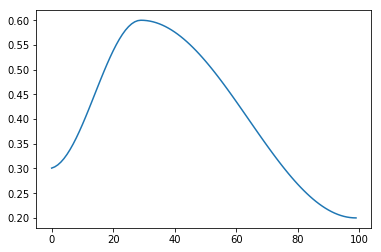

In [115]:
a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)
plt.plot(a, [sched(o) for o in p])

In [119]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [120]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [121]:
run.fit(3, learn)

train: [0.76577390625, tensor(0.7903)]
valid: [0.332855859375, tensor(0.9022)]
train: [0.2976534375, tensor(0.9124)]
valid: [0.2334689453125, tensor(0.9324)]
train: [0.2353909375, tensor(0.9332)]
valid: [0.211158984375, tensor(0.9407)]


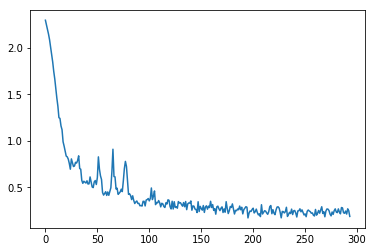

In [123]:
run.recorder.plot_loss()

## Export

In [90]:
!python notebook2script.py annealing.ipynb

Converted annealing.ipynb to exp/nb_annealing.py
